## Data loading

First we need to load the MNIST dataset from disk. We will do 10-class classification for digit 0, 1, .., 9 from the MNIST dataset here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import edf
import mnist_loader
import copy

train_images, train_labels = mnist_loader.load_mnist(section='training', path='MNIST')
val_images, val_labels = mnist_loader.load_mnist(section='testing', path='MNIST')

# quickly check the shape of data
print('Train data shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Validation data shape: ', val_images.shape)
print('Validation labels shape: ', val_labels.shape)


Train data shape:  (60000, 28, 28)
Train labels shape:  (60000,)
Validation data shape:  (10000, 28, 28)
Validation labels shape:  (10000,)


## A multi-layer perceptron (MLP) network with dropout

**3.3.(a).** We produce the multi-layer perceptron (MLP) class. In this assignment, we implement dropout by adding `dropout` layers between hidden layers. The MLP framework is defined below so your task is to implement parts of `dropout` computational nodes. To help your understanding, I recommend you to draw the computational graph of a 2-layer MLP network including loss nodes. As in the previous exercises, you can group the computation nodes to simplify the drawing e.g. (Affine -> Activation) can be grouped into a single hiddne layer node.

Here, we provide a `ReLU` activation node and computational nodes for our MLP network. 

In [3]:
# Add
class Add(edf.CompNode):
    def __init__(self, x_list):
        edf.CompNodes.append(self)
        self.x_list = x_list

    def forward(self):
        value = np.zeros_like(self.x_list[0].value, self.x_list[0].value.dtype)
        for x in self.x_list:
            value += x.value
        self.value = value

    def backward(self):
        for x in self.x_list:
            x.addgrad(np.ones_like(x.value, x.value.dtype)* self.grad[0]) 

# Average loss over a minibach
class AverageMiniBatch(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        value = np.average(self.x.value)
        self.value = np.resize(value, (1, 1))

    def backward(self):
        self.x.addgrad(np.ones_like(self.x.value, self.x.value.dtype)/self.x.value.size* self.grad[0]) 

# ReLU
class ReLU(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        self.value = np.maximum(0, self.x.value)

    def backward(self):
        v = np.ones_like(self.x.value)
        v[self.x.value <= 0.0] = 0.0
        self.x.addgrad(self.grad * v)

In [4]:
# MLP
class MLP:
    def __init__(
        self,
        nInputs,
        nHiddens,
        nOutputs,
        nLayers,
        ActivationClass,
        RegClass=None,
        alpha=None,
        dropOutProb=None,
        DropOutClass=None,
    ):
        self.nInputs = nInputs
        self.nHiddens = nHiddens
        self.nOutputs = nOutputs
        self.nLayers = nLayers
        self.ActivationClass = ActivationClass
        self.RegClass = RegClass
        self.alpha = alpha
        self.dropOutProb = dropOutProb

        edf.clear_compgraph()
        weight_params = []
        loss_nodes = []
        layer_shapes = [nInputs,] + [nHiddens,]*nLayers + [nOutputs,]

        x_node = edf.Input()
        y_node = edf.Input()
        
        h = x_node
        for i in range(1, len(layer_shapes)):
            param = edf.AffineParams(layer_shapes[i - 1], layer_shapes[i])
            weight_params.append(param)
            if i < len(layer_shapes) - 1: # if not last layer
                if dropOutProb > 0:
                    h = DropOutClass(ActivationClass(edf.Affine(param, h)), dropOutProb)
                else:
                    h = ActivationClass(edf.Affine(param, h))
            else: 
                h = edf.Softmax(edf.Affine(param, h))
            if RegClass is not None:
                reg_loss_node = self.RegClass(param.A, alpha)
                loss_nodes.append(reg_loss_node)

        crossloss_node = edf.CrossEntropyLoss(h, y_node)
        sum_node = AverageMiniBatch(crossloss_node)
        loss_nodes.append(sum_node)

        self.prob_node = h
        self.output_node = h
        self.total_loss_node = Add(loss_nodes)
        self.x_node = x_node
        self.y_node = y_node
        self.weight_params = weight_params

    def forward(self, X, y=None):
        if y is None:
            y = np.ones_like(X[:,0], dtype =np.int32)

        self.x_node.value = X
        self.y_node.value = y

        edf.Forward()
        output = self.output_node.value

        return output


## Dropout

**3.3.(b).** Implement backward and forward parts of a `Dropout` node. In the forward function, we first generate a random mask according to the dropout probability. Then, we filter out the input signal, using the mask. Instead of downscaling the output by the probability of keeping a neuron when dropout is not used (test time), you should scale the output with the inverse of this value when the dropout is used (this is commonly know as 'inverted dropout'). In the backward function, we do backpropagation only on the valid parts (defined by the mask). Note that dropout should be performed during training. To this end, we use `edf.enable_dropout` to specify whether dropout should be performed or not. If `edf.enable_dropout` is false, this node gives input as output without any operation.

In [37]:
# Dropout
class DropOut(edf.CompNode):
    def __init__(self, x, dropout_prob=0.5):
        edf.CompNodes.append(self)
        self.x = x
        self.dropout_prob = dropout_prob

    def forward(self):
        mask = np.ones_like(self.x)
        value = self.x.value
        if edf.enable_dropout:
            # TODO: implement the forward part of a dropout computation node
            # when dropout is activated,
            # you first generate a random mask which has the same size as input x
            # then you filter out signal x according to the generated mask, and 
            # scale this signal with 1/(1-d_p)

            mask = np.random.binomial(1, self.dropout_prob, self.x.value.shape)
            value = value[mask] = 0
            value *= 1 / (1 - self.dropout_prob)

        self.mask = np.array(mask ,dtype = edf.DT)
        self.value = value
        
    def backward(self):
        # TODO: implement the backward part of a dropout computation node
        # compute the gradient while considering the mask we used for forward
        g = self.grad[self.mask.astype(bool)] = 0
        self.x.addgrad(g)

We provide functions for training. By passing `optimizer` and `transform` objects into `train_and_test` function, we can train the network with various optimization methods and data augmentations. The `transformer` class we will discuss later. Here we provide the basic optimizer, which updates the parameters based on the gradients and the learning rate. Note that the learning rate is multiplied with the gradient and the multiplication result is added to the parameters in `p.UpdateParameters()`. Please see the `edf.py` for details.

In [34]:
# basic gradient descent method
class GDOptimizer:
    def __init__(self):
        print('')

    def initialize(self):
        print('')
           
    def updateParameters (self):
        for p in edf.Parameters:
            p.UpdateParameters()


In [35]:
def run_epoch(batch_size, data, labels, x_node, y_node, prob_node, loss_node=None, optimizer=GDOptimizer(), transform=None):
    num_samples = len(data)
    total_err = 0.
    num_batches = num_samples // batch_size

    for i in range(num_batches):
        start, end = i * batch_size, (i + 1) * batch_size

        if transform is None:
            x_node.value = data[start:end].reshape(end - start, -1)
        else:
            x_node.value = transform.apply(data[start: end]).reshape(end - start, -1)
        y_node.value = labels[start: end]
        edf.Forward()
        total_err += np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))

        if loss_node:
            edf.Backward(loss_node)
            optimizer.updateParameters()

        if i > 0 and i % 400 == 0:
            print (f'\t Batch {i}/{num_batches}')

    return 100 * total_err / num_samples

def train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node, optimizer=GDOptimizer(), transform=None, enable_dropout=False):
    train_err_log = []
    val_err_log = []
    
    optimizer.initialize()
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs} (learning rate: {edf.learning_rate})'.format(epoch+1, num_epochs, edf.learning_rate))

        edf.enable_dropout = enable_dropout
        train_err = run_epoch(batch_size, train_images, train_labels, x_node, y_node, prob_node, loss_node, optimizer, transform)
        train_err_log.append(train_err)
        print (f'\t Training error {train_err:.2f}%')

        edf.enable_dropout = False
        val_err = run_epoch(len(val_images), val_images, val_labels, x_node, y_node, prob_node, None, optimizer, None)
        val_err_log.append(val_err)
        print (f'\t Validation error {val_err:.2f}%')
        
        for i in range(10):
            err_n_per_i = np.sum(np.not_equal(np.argmax(prob_node.value[y_node.value == i], axis=1), y_node.value[y_node.value == i]))
            n_per_i = np.sum(y_node.value == i)
            print(f'{i} : {err_n_per_i}/{n_per_i}  {100 * err_n_per_i / n_per_i:.2f}%')
        

    return train_err_log, val_err_log

def plot(train_err_log, val_err_log):
    plt.xlabel('epochs')
    plt.ylabel('error (%)')
    plt.plot(np.arange(len(val_err_log)), val_err_log, color='red')
    plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
    plt.legend(['val error', 'train error'], loc='upper right')
    plt.show()
    plt.close()

**3.3.(b).i.** Construct an MLP network with the arameters as defined below. You can activate norm regularization by adding regularization class in this jupyter notebook and changing parameter settings but make sure that for evaluation and answering quiz questions you use unmodified parameter settings and random seed. After constructing the MLP network, train the network and show the error graph.


Epoch: 1/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 65.42%
	 Validation error 53.54%
0 : 302/980  30.82%
1 : 64/1135  5.64%
2 : 667/1032  64.63%
3 : 397/1010  39.31%
4 : 571/982  58.15%
5 : 814/892  91.26%
6 : 877/958  91.54%
7 : 246/1028  23.93%
8 : 483/974  49.59%
9 : 933/1009  92.47%
Epoch: 2/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 51.62%
	 Validation error 49.18%
0 : 242/980  24.69%
1 : 64/1135  5.64%
2 : 633/1032  61.34%
3 : 443/1010  43.86%
4 : 505/982  51.43%
5 : 720/892  80.72%
6 : 762/958  79.54%
7 : 272/1028  26.46%
8 : 472/974  48.46%
9 : 805/1009  79.78%
Epoch: 3/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 49.01%
	 Validation error 47.00%
0 : 233/980  23.78%
1 : 66/1135  5.81%
2 : 620/1032  60.08%
3 : 470/1010  46.53%
4 : 484/982  49.29%
5 : 672/892  75.34%
6 : 691/958  72.13%
7 : 283/1028  27.53%
8 : 456/974  46.82%
9 : 725/1009  71.85%
Epoch: 4/20 (learning rate: 0.1)
	 Batch 400/

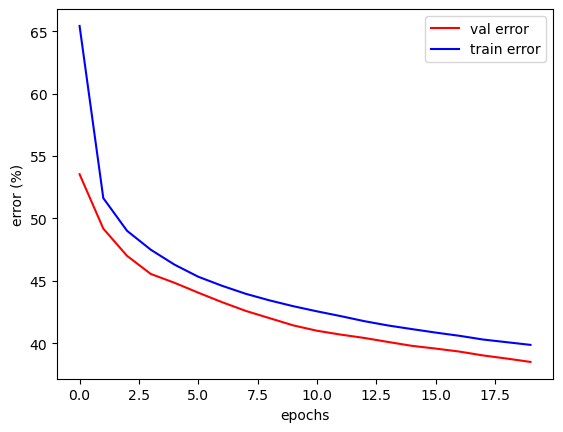

In [39]:
nInputs = 784 
nOutputs = 10 
nLayers = 3
nHiddens = 64
ActivationClass = ReLU
RegClass = None
alpha = 0.
dropOutProb = 0.5
DropOutClass = DropOut

mlp_ReLU = MLP(nInputs, nHiddens, nOutputs, nLayers, ActivationClass, RegClass, alpha, dropOutProb, DropOutClass)

num_epochs = 20
batch_size = 64
edf.learning_rate = 0.1

edf.enable_dropout = True

# TODO: call the train_and_test with dropout mode and plot the error graph

train_err_log, val_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.total_loss_node)

plot(train_err_log, val_err_log)

**3.3.(b).ii.** Train the network without dropout.


Epoch: 1/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 11.79%
	 Validation error 6.66%
0 : 18/980  1.84%
1 : 17/1135  1.50%
2 : 107/1032  10.37%
3 : 68/1010  6.73%
4 : 66/982  6.72%
5 : 120/892  13.45%
6 : 38/958  3.97%
7 : 108/1028  10.51%
8 : 70/974  7.19%
9 : 54/1009  5.35%
Epoch: 2/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 4.82%
	 Validation error 4.61%
0 : 13/980  1.33%
1 : 9/1135  0.79%
2 : 69/1032  6.69%
3 : 56/1010  5.54%
4 : 41/982  4.18%
5 : 61/892  6.84%
6 : 42/958  4.38%
7 : 82/1028  7.98%
8 : 40/974  4.11%
9 : 48/1009  4.76%
Epoch: 3/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 3.50%
	 Validation error 3.97%
0 : 11/980  1.12%
1 : 9/1135  0.79%
2 : 57/1032  5.52%
3 : 47/1010  4.65%
4 : 31/982  3.16%
5 : 39/892  4.37%
6 : 46/958  4.80%
7 : 75/1028  7.30%
8 : 27/974  2.77%
9 : 55/1009  5.45%
Epoch: 4/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 2.82%
	 Validation

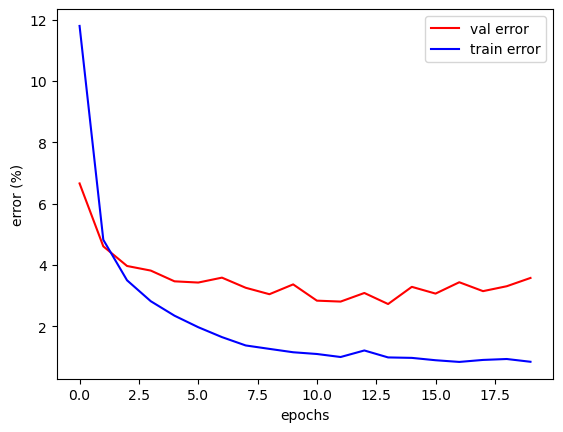

In [40]:
np.random.seed(1234)

nInputs = 784
nOutputs = 10
nLayers = 3
nHiddens = 64
ActivationClass = ReLU
RegClass = None
alpha = 0.
dropOutProb = 0.
DropOutClass = None

mlp_ReLU = MLP(nInputs, nHiddens, nOutputs, nLayers, ActivationClass, RegClass, alpha, dropOutProb, DropOutClass)

#Train
num_epochs = 20
batch_size = 64
edf.learning_rate = 0.1

edf.enable_dropout = False

# TODO: call the train_and_test without dropout mode and plot the error graph

train_err_log, val_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.total_loss_node)

plot(train_err_log, val_err_log)

## Optimization methods

**3.3.(c).** Implement two advanced optimizers: RMSProp and Adam. Our strategy is to store addtional variables such as uncentered variance and velocity in each node. Then we modify gradients by using stored variables after backpropagation. For example, you can refer to `AdaGradOptimizer` optimization class to understand how implementing a different optimization method could be done in edf (you don't have to know about AdaGrad). Note that `p.UpdateParameter()` updates the parameter by adding the multiplication of the ***learning rate*** and the gradient. So, our optimizer computes the update step (without the learning rate) then stores it as the gradient.

**3.3.(c).i** Let's implement `RMSPropOptimizer` first. We have to implement two parts: `initialize` and `updateParameters`. `initialize` function initializes the auxiliary variables. `updateParameters` function modifies the gradients according to each optimization method then updates the parameters. 



In [41]:
class AdaGradOptimizer:
    epsilon = 0.001

    def __init__(self,  epsilon=0.001):
        self.epsilon = epsilon

    def initialize(self):
        for p in edf.Parameters:
            p.accum_mag = np.zeros_like ( p.value )
        
    def updateParameters (self):
        for p in edf.Parameters:
            p.accum_mag += p.grad**2 
            p.grad = p.grad / np.sqrt(self.epsilon + p.accum_mag)
            p.UpdateParameters()

class RMSPropOptimizer:
    beta = None
    epsilon = 0.001

    def __init__(self, beta, epsilon=0.001):
        self.beta = beta
        self.epsilon = epsilon

    def initialize(self):
        # TODO: initialize the uncentered variance of parameters 
        for p in edf.Parameters:
            p.variance = np.zeros_like(p.value)

    def updateParameters(self):
        for p in edf.Parameters:
            # TODO: compute the uncentered variance then update the gradient
            # Hint: learning rate will be multiplied in p.UpdateParameters()
            p.variance = self.beta * p.variance + (1 - self.beta) * p.grad**2         
            p.grad /= np.sqrt(p.variance) + self.epsilon
            p.UpdateParameters()


**3.3.(c).i**  Here we set the `MLP` parameters. Then, we construct the MLP network and train the network by using  `RMSPropOptimizer`. 

Epoch: 1/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training error 9.04%
	 Validation error 5.88%
0 : 11/980  1.12%
1 : 14/1135  1.23%
2 : 69/1032  6.69%
3 : 77/1010  7.62%
4 : 41/982  4.18%
5 : 44/892  4.93%
6 : 67/958  6.99%
7 : 136/1028  13.23%
8 : 78/974  8.01%
9 : 51/1009  5.05%
Epoch: 2/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training error 4.38%
	 Validation error 4.33%
0 : 9/980  0.92%
1 : 11/1135  0.97%
2 : 51/1032  4.94%
3 : 55/1010  5.45%
4 : 46/982  4.68%
5 : 35/892  3.92%
6 : 61/958  6.37%
7 : 95/1028  9.24%
8 : 33/974  3.39%
9 : 37/1009  3.67%
Epoch: 3/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training error 3.19%
	 Validation error 3.79%
0 : 13/980  1.33%
1 : 9/1135  0.79%
2 : 53/1032  5.14%
3 : 43/1010  4.26%
4 : 40/982  4.07%
5 : 29/892  3.25%
6 : 56/958  5.85%
7 : 73/1028  7.10%
8 : 29/974  2.98%
9 : 34/1009  3.37%
Epoch: 4/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training error 2.51%
	 Validation e

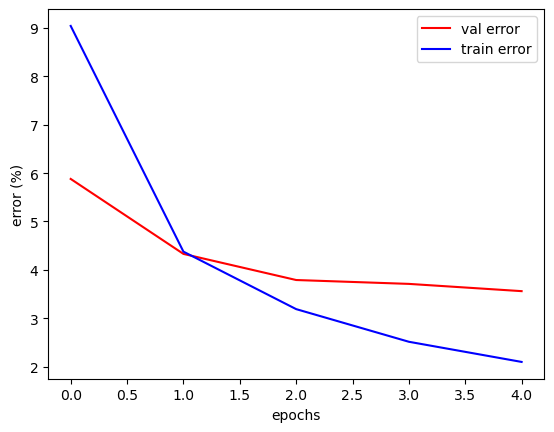

In [43]:
nInputs = 784 
nOutputs = 10 
nLayers = 3
nHiddens = 64 
ActivationClass = ReLU
RegClass = None
alpha = 0.
dropOutProb = 0.
DropOutClass = None
# dropOutProb = 0.2
# DropOutClass = DropOut

mlp_ReLU = MLP(nInputs, nHiddens, nOutputs, nLayers, ActivationClass, RegClass, alpha, dropOutProb, DropOutClass)

#Train
num_epochs = 5
batch_size = 64
edf.learning_rate = 0.001

# TODO: Generate the RMSPropOptimizer instance 
# You can set parameter (beta, epsilon) = (0.9, 1e-5)
optimizer = RMSPropOptimizer(0.9, 1e-5)

train_err_log, val_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.total_loss_node, optimizer, enable_dropout=(DropOutClass is not None and dropOutProb != 0))
plot(train_err_log, val_err_log)

**3.3.(c).ii** In this part, we implement `AdamOptimizer`. We have to complete two functions: `initialize` and `updateParameters`. `initialize` function initializes the auxiliary variables. `updateParameters` function modifies the gradients according to each optimization method and then updates the parameters. 

In [57]:
class AdamOptimizer:
    beta_1 = None
    beta_2 = None
    beta_1_t = None
    beta_2_t = None
    epsilon = 0.001

    def __init__(self, beta_1, beta_2, epsilon=0.001):
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.beta_1_t = beta_1
        self.beta_2_t = beta_2

    def initialize (self):
        for p in edf.Parameters:
            # TODO: initialize velocity, uncentered variance, beta_1_t and beta_2_t
            # Hint:  velocity and uncentered variance should be zero matrices
            p.variance = np.zeros_like(p.value)
            p.velocity = np.zeros_like(p.value)
            
            
    def updateParameters(self):
        # TODO: update beta_1_t, beta_2_t
        
        self.beta_1_t *= self.beta_1
        self.beta_2_t *= self.beta_2
        
        for p in edf.Parameters:
            # TODO: compute velocity and uncentered variance and update the gradient with corrected update step
            # Hint: refer to Slide 32 of lecture 6 pdf
            
            p.velocity = self.beta_1 * p.velocity + (1 - self.beta_1) * p.grad
            p.velocity /= 1 - self.beta_1_t
            
            p.variance = self.beta_2 * p.variance + (1 - self.beta_2) * p.grad**2
            p.variance /= 1 - self.beta_2_t
            
            p.grad = p.velocity / (np.sqrt(p.variance) + self.epsilon)
            
            p.UpdateParameters()
        


Epoch: 1/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training error 23.34%
	 Validation error 11.30%
0 : 23/980  2.35%
1 : 15/1135  1.32%
2 : 147/1032  14.24%
3 : 135/1010  13.37%
4 : 148/982  15.07%
5 : 108/892  12.11%
6 : 127/958  13.26%
7 : 97/1028  9.44%
8 : 248/974  25.46%
9 : 82/1009  8.13%
Epoch: 2/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training error 9.51%
	 Validation error 7.88%
0 : 17/980  1.73%
1 : 13/1135  1.15%
2 : 97/1032  9.40%
3 : 76/1010  7.52%
4 : 100/982  10.18%
5 : 97/892  10.87%
6 : 115/958  12.00%
7 : 72/1028  7.00%
8 : 129/974  13.24%
9 : 72/1009  7.14%
Epoch: 3/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training error 7.64%
	 Validation error 6.63%
0 : 29/980  2.96%
1 : 11/1135  0.97%
2 : 63/1032  6.10%
3 : 74/1010  7.33%
4 : 66/982  6.72%
5 : 95/892  10.65%
6 : 71/958  7.41%
7 : 64/1028  6.23%
8 : 105/974  10.78%
9 : 85/1009  8.42%
Epoch: 4/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training er

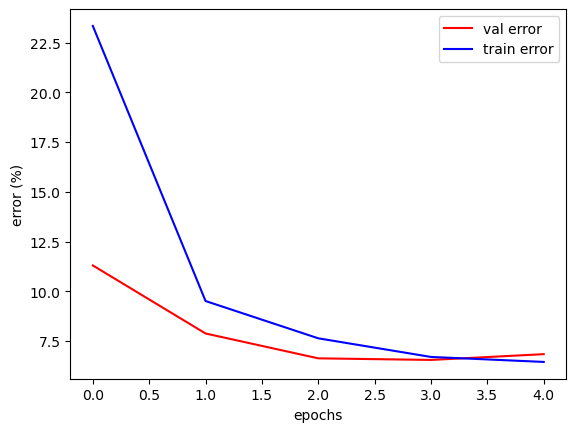

In [58]:
nInputs = 784 
nOutputs = 10 
nLayers = 3
nHiddens = 64
ActivationClass = ReLU
RegClass = None
alpha = 0.
dropOutProb = 0.
DropOutClass = None
# dropOutProb = 0.2
# DropOutClass = DropOut

mlp_ReLU = MLP(nInputs, nHiddens, nOutputs, nLayers, ActivationClass, RegClass, alpha, dropOutProb, DropOutClass)

# train
num_epochs = 5
batch_size = 64
edf.learning_rate = 0.001

# TODO: Generate the AdamOptimizer instance
# You can set parameter (beta_1, beta_2, epsilon) = (0.9, 0.9, 1e-8)
optimizer = AdamOptimizer(0.9, 0.9, 1e-8)

train_err_log, val_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.total_loss_node, optimizer, enable_dropout=(DropOutClass is not None and dropOutProb != 0))
plot(train_err_log, val_err_log)

## Data augmentation: vertical and horizontal flip

**3.3.d.i** In this assignment, instead of increasing the variety of valid data pools, we pollute the training data set by flipping images. Lets check how the accuracy changes. To augment the dataset, we now implement the augmentation  class. We transform the input data before the network is trained. Your task is to fill in `RandomFlipAug` class. You can refer to other augmentation classes to understand how the augmentation class works.

In [62]:
# Data augmentation
# Gaussian noise
class RandomNoiseAug:
    amplitude_max = 10

    def __init__(self, amplitude_max):
        self.amplitude_max = amplitude_max

    def apply(self, x):
        image_n = x.shape[0]
        x_new = copy.deepcopy(x)

        noise_max = np.random.rand(image_n, 1, 1 ) * self.amplitude_max
        gaussian_noise = np.random.randn(x.shape[0], x.shape[1],x.shape[2])
        gaussian_noise = noise_max * gaussian_noise

        x_new = gaussian_noise + x_new
        x_new[x_new < 0] = 0
        x_new[x_new > 1] = 1

        return x_new

# Translation
class RandomTranslationAug:
    width = None

    def __init__(self, width):
        self.width = width

    def apply(self, x):
        image_n = x.shape[0]
        x_new = copy.deepcopy(x)

        trans_cols = np.array(np.round(np.random.rand ( image_n ) * self.width - 0.4999), dtype = np.int32 )
        trans_rows = np.array(np.round(np.random.rand ( image_n ) * self.width - 0.4999), dtype = np.int32 )

        trans_cols -= int(self.width/2)
        trans_rows -= int(self.width/2)

        # translate for each imgae
        for i in range(0, image_n):
            # wrapping
            x_temp = np.tile(x[i, :, :], [3, 3])

            trans_col = int(trans_cols[i])
            trans_row = int(trans_rows[i])

            x_new[i, :, :] = x_temp[x.shape[1] + trans_row:x.shape[1] * 2 + trans_row, x.shape[2] + trans_col:x.shape[2] * 2 + trans_col]

        return x_new

class RandomFlipAug:
    flip_prob_vertical = 0.5
    flip_prob_horizontal = 0.5

    def __init__(self, prob_vertical, prob_horizontal):
        self.flip_prob_vertical = prob_vertical
        self.flip_prob_horizontal = prob_horizontal

    def apply(self, x):
        image_n = x.shape[0]
        x_new = copy.deepcopy(x)
       
        if np.random.rand(1) < self.flip_prob_horizontal:
            x_new = np.flipud(x_new).copy()
        if np.random.rand(1) < self.flip_prob_vertical:
            x_new = np.fliplr(x_new).copy()

        return x_new

**3.3.d.ii** Check the performance after we flip the training dataset horizontally.


Epoch: 1/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 88.92%
	 Validation error 89.73%
0 : 980/980  100.00%
1 : 1077/1135  94.89%
2 : 1032/1032  100.00%
3 : 1006/1010  99.60%
4 : 982/982  100.00%
5 : 892/892  100.00%
6 : 958/958  100.00%
7 : 63/1028  6.13%
8 : 974/974  100.00%
9 : 1009/1009  100.00%
Epoch: 2/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 88.84%
	 Validation error 91.15%
0 : 980/980  100.00%
1 : 1125/1135  99.12%
2 : 1031/1032  99.90%
3 : 988/1010  97.82%
4 : 982/982  100.00%
5 : 892/892  100.00%
6 : 957/958  99.90%
7 : 177/1028  17.22%
8 : 974/974  100.00%
9 : 1009/1009  100.00%
Epoch: 3/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 88.55%
	 Validation error 91.54%
0 : 980/980  100.00%
1 : 1118/1135  98.50%
2 : 1029/1032  99.71%
3 : 982/1010  97.23%
4 : 978/982  99.59%
5 : 892/892  100.00%
6 : 953/958  99.48%
7 : 247/1028  24.03%
8 : 973/974  99.90%
9 : 1002/1009  99.31%
Epoch: 4/10 (lear

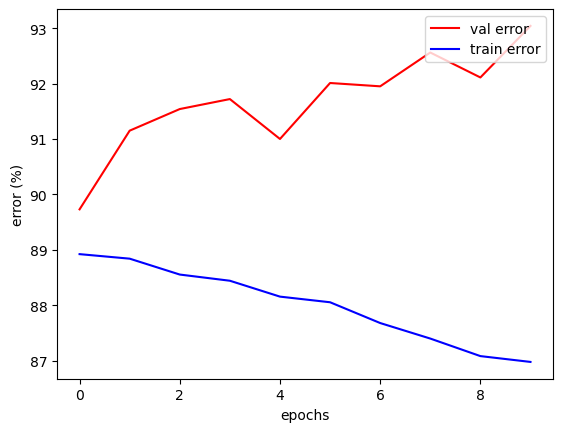

In [63]:
np.random.seed(1234)

nInputs = 784
nOutputs = 10
nLayers = 3
nHiddens = 64
ActivationClass = ReLU
RegClass = None
alpha = 0.
dropOutProb = 0.
DropOutClass = None
# dropOutProb = 0.2
# DropOutClass = DropOut

mlp_ReLU = MLP(nInputs, nHiddens, nOutputs, nLayers, ActivationClass, RegClass, alpha, dropOutProb, DropOutClass)

# train
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.1

# Horizontal flip
# TODO: generate the RandomFlipAug instance which always flips images horizontally
aug_obj = RandomFlipAug(0, 1)

train_err_log, val_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.total_loss_node, transform=aug_obj, enable_dropout=(DropOutClass is not None and dropOutProb != 0))
plot(train_err_log, val_err_log)

**3.3.d.iii** Check the performance after we flip the training dataset vertically. 


Epoch: 1/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 10.87%
	 Validation error 68.08%
0 : 296/980  30.20%
1 : 239/1135  21.06%
2 : 996/1032  96.51%
3 : 304/1010  30.10%
4 : 578/982  58.86%
5 : 856/892  95.96%
6 : 958/958  100.00%
7 : 1001/1028  97.37%
8 : 687/974  70.53%
9 : 893/1009  88.50%
Epoch: 2/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 5.39%
	 Validation error 65.98%
0 : 329/980  33.57%
1 : 103/1135  9.07%
2 : 998/1032  96.71%
3 : 271/1010  26.83%
4 : 485/982  49.39%
5 : 876/892  98.21%
6 : 958/958  100.00%
7 : 1006/1028  97.86%
8 : 645/974  66.22%
9 : 927/1009  91.87%
Epoch: 3/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training error 3.82%
	 Validation error 64.72%
0 : 322/980  32.86%
1 : 77/1135  6.78%
2 : 1000/1032  96.90%
3 : 273/1010  27.03%
4 : 500/982  50.92%
5 : 882/892  98.88%
6 : 958/958  100.00%
7 : 1014/1028  98.64%
8 : 540/974  55.44%
9 : 906/1009  89.79%
Epoch: 4/10 (learning rate: 0.1)
	 Ba

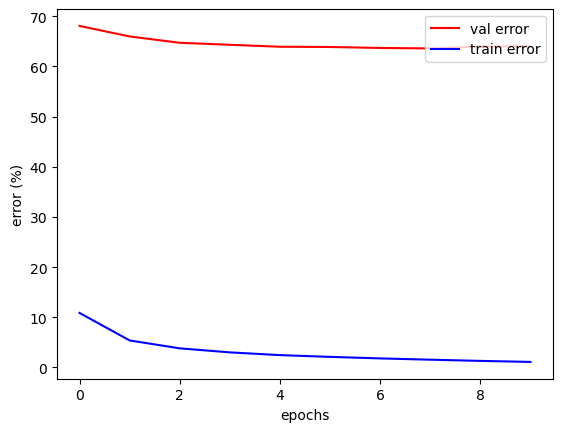

In [64]:
nInputs = 784
nOutputs = 10
nLayers = 2
nHiddens = 64
ActivationClass = ReLU
RegClass = None
alpha = 0.
dropOutProb = 0.
DropOutClass = None
# dropOutProb = 0.2
# DropOutClass = DropOut

mlp_ReLU = MLP(nInputs, nHiddens, nOutputs, nLayers, ActivationClass, RegClass, alpha, dropOutProb, DropOutClass)

#train
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.1

# Vertical flip
# TODO : generate the RandomFlipAug instance which always flips images vertically
aug_obj = RandomFlipAug(1, 0)

train_err_log, test_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.total_loss_node, transform=aug_obj, enable_dropout=(DropOutClass is not None and dropOutProb != 0))
plot(train_err_log, test_err_log)